# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Доступны исторические данные о поведении клиентов и расторжении договоров с банком. 

Нужно построить модель с предельно большим значением *F1*-меры, не менее 0,59

**Описание данных**

    RowNumber — индекс строки в данных
    CustomerId — уникальный идентификатор клиента
    Surname — фамилия
    CreditScore — кредитный рейтинг
    Geography — страна проживания
    Gender — пол
    Age — возраст
    Tenure — сколько лет человек является клиентом банка
    Balance — баланс на счёте
    NumOfProducts — количество продуктов банка, используемых клиентом
    HasCrCard — наличие кредитной карты
    IsActiveMember — активность клиента
    EstimatedSalary — предполагаемая зарплата
    Exited — факт ухода клиента

**План проекта**

    1.Подготовка данных
    2.Исследование задачи
    3.Борьба с дисбалансом
    4.Тестирование модели
    Заключение

## 1. Подготовка данных

- посмотрим на исходные данные - размер, типы, пропуски, корреляцию
- обработаем пропуски
- удалим незначимые признаки
- сделаем ohe преобразование
- маштабируем данные
- выделим 3 набора фичей и тагетов

In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool, cv
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, roc_auc_score, recall_score, precision_recall_curve, roc_curve, \
             accuracy_score, mean_squared_error, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
%config InlineBackend.figure_format='retina'
warnings.simplefilter('ignore')
sns.set_palette('pastel')
sns.set_style('white')

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [3]:
data.columns = data.columns.str.lower()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           9091 non-null   float64
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
data.describe().round(2)

,rownumber,customerid,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
count,10000.00,10000.00,10000.00,10000.00,9091.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.0
mean,5000.50,15690940.57,650.53,38.92,5.00,76485.89,1.53,0.71,0.52,100090.24,0.2
std,2886.90,71936.19,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.4
min,1.00,15565701.00,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.0
25%,2500.75,15628528.25,584.00,32.00,2.00,0.00,1.00,0.00,0.00,51002.11,0.0
50%,5000.50,15690738.00,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.92,0.0
75%,7500.25,15753233.75,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.0
max,10000.00,15815690.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.0


In [6]:
no_tenure_data = data[data.tenure.isna()]
no_tenure_data.describe().round()

,rownumber,customerid,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
count,909.0,909.0,909.0,909.0,0.0,909.0,909.0,909.0,909.0,909.0,909.0
mean,4866.0,15689815.0,648.0,39.0,NaN,76117.0,2.0,1.0,1.0,99180.0,0.0
std,2910.0,75112.0,99.0,10.0,NaN,63106.0,1.0,0.0,1.0,56378.0,0.0
min,31.0,15565806.0,359.0,18.0,NaN,0.0,1.0,0.0,0.0,107.0,0.0
25%,2311.0,15626578.0,580.0,32.0,NaN,0.0,1.0,0.0,0.0,49872.0,0.0
50%,4887.0,15686870.0,647.0,37.0,NaN,96675.0,1.0,1.0,1.0,99444.0,0.0
75%,7306.0,15756804.0,718.0,43.0,NaN,128555.0,2.0,1.0,1.0,145760.0,0.0
max,10000.0,15815690.0,850.0,92.0,NaN,206664.0,4.0,1.0,1.0,199390.0,1.0


Присутствует дисбаланс классов целевого признака

In [7]:
data.exited.value_counts()

0    7963
1    2037
Name: exited, dtype: int64

In [8]:
no_tenure_data.exited.value_counts()

0    726
1    183
Name: exited, dtype: int64

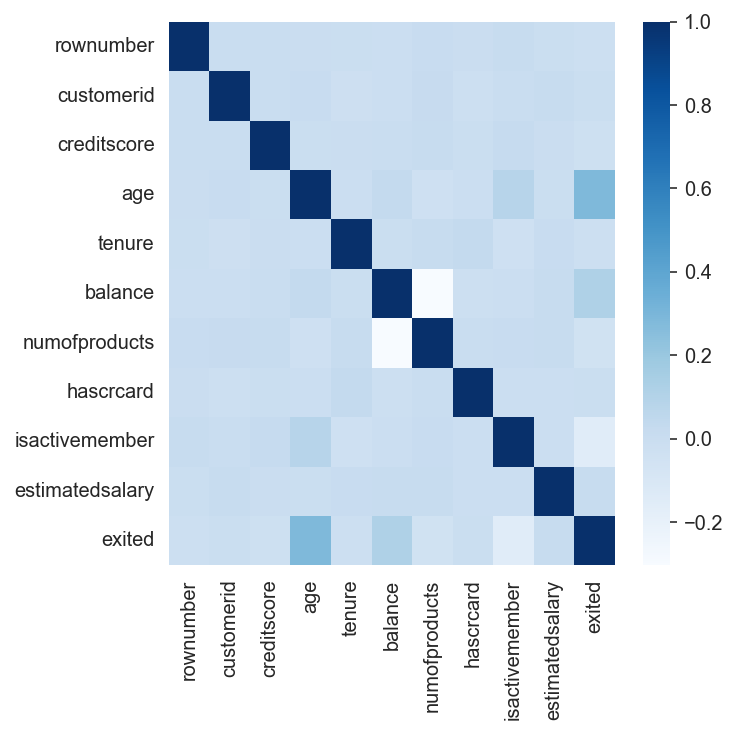

In [9]:
plt.figure(figsize=(5,5))
sns.heatmap(data.corr(), cmap='Blues', annot=False)
plt.show()

<Figure size 1512x1512 with 0 Axes>

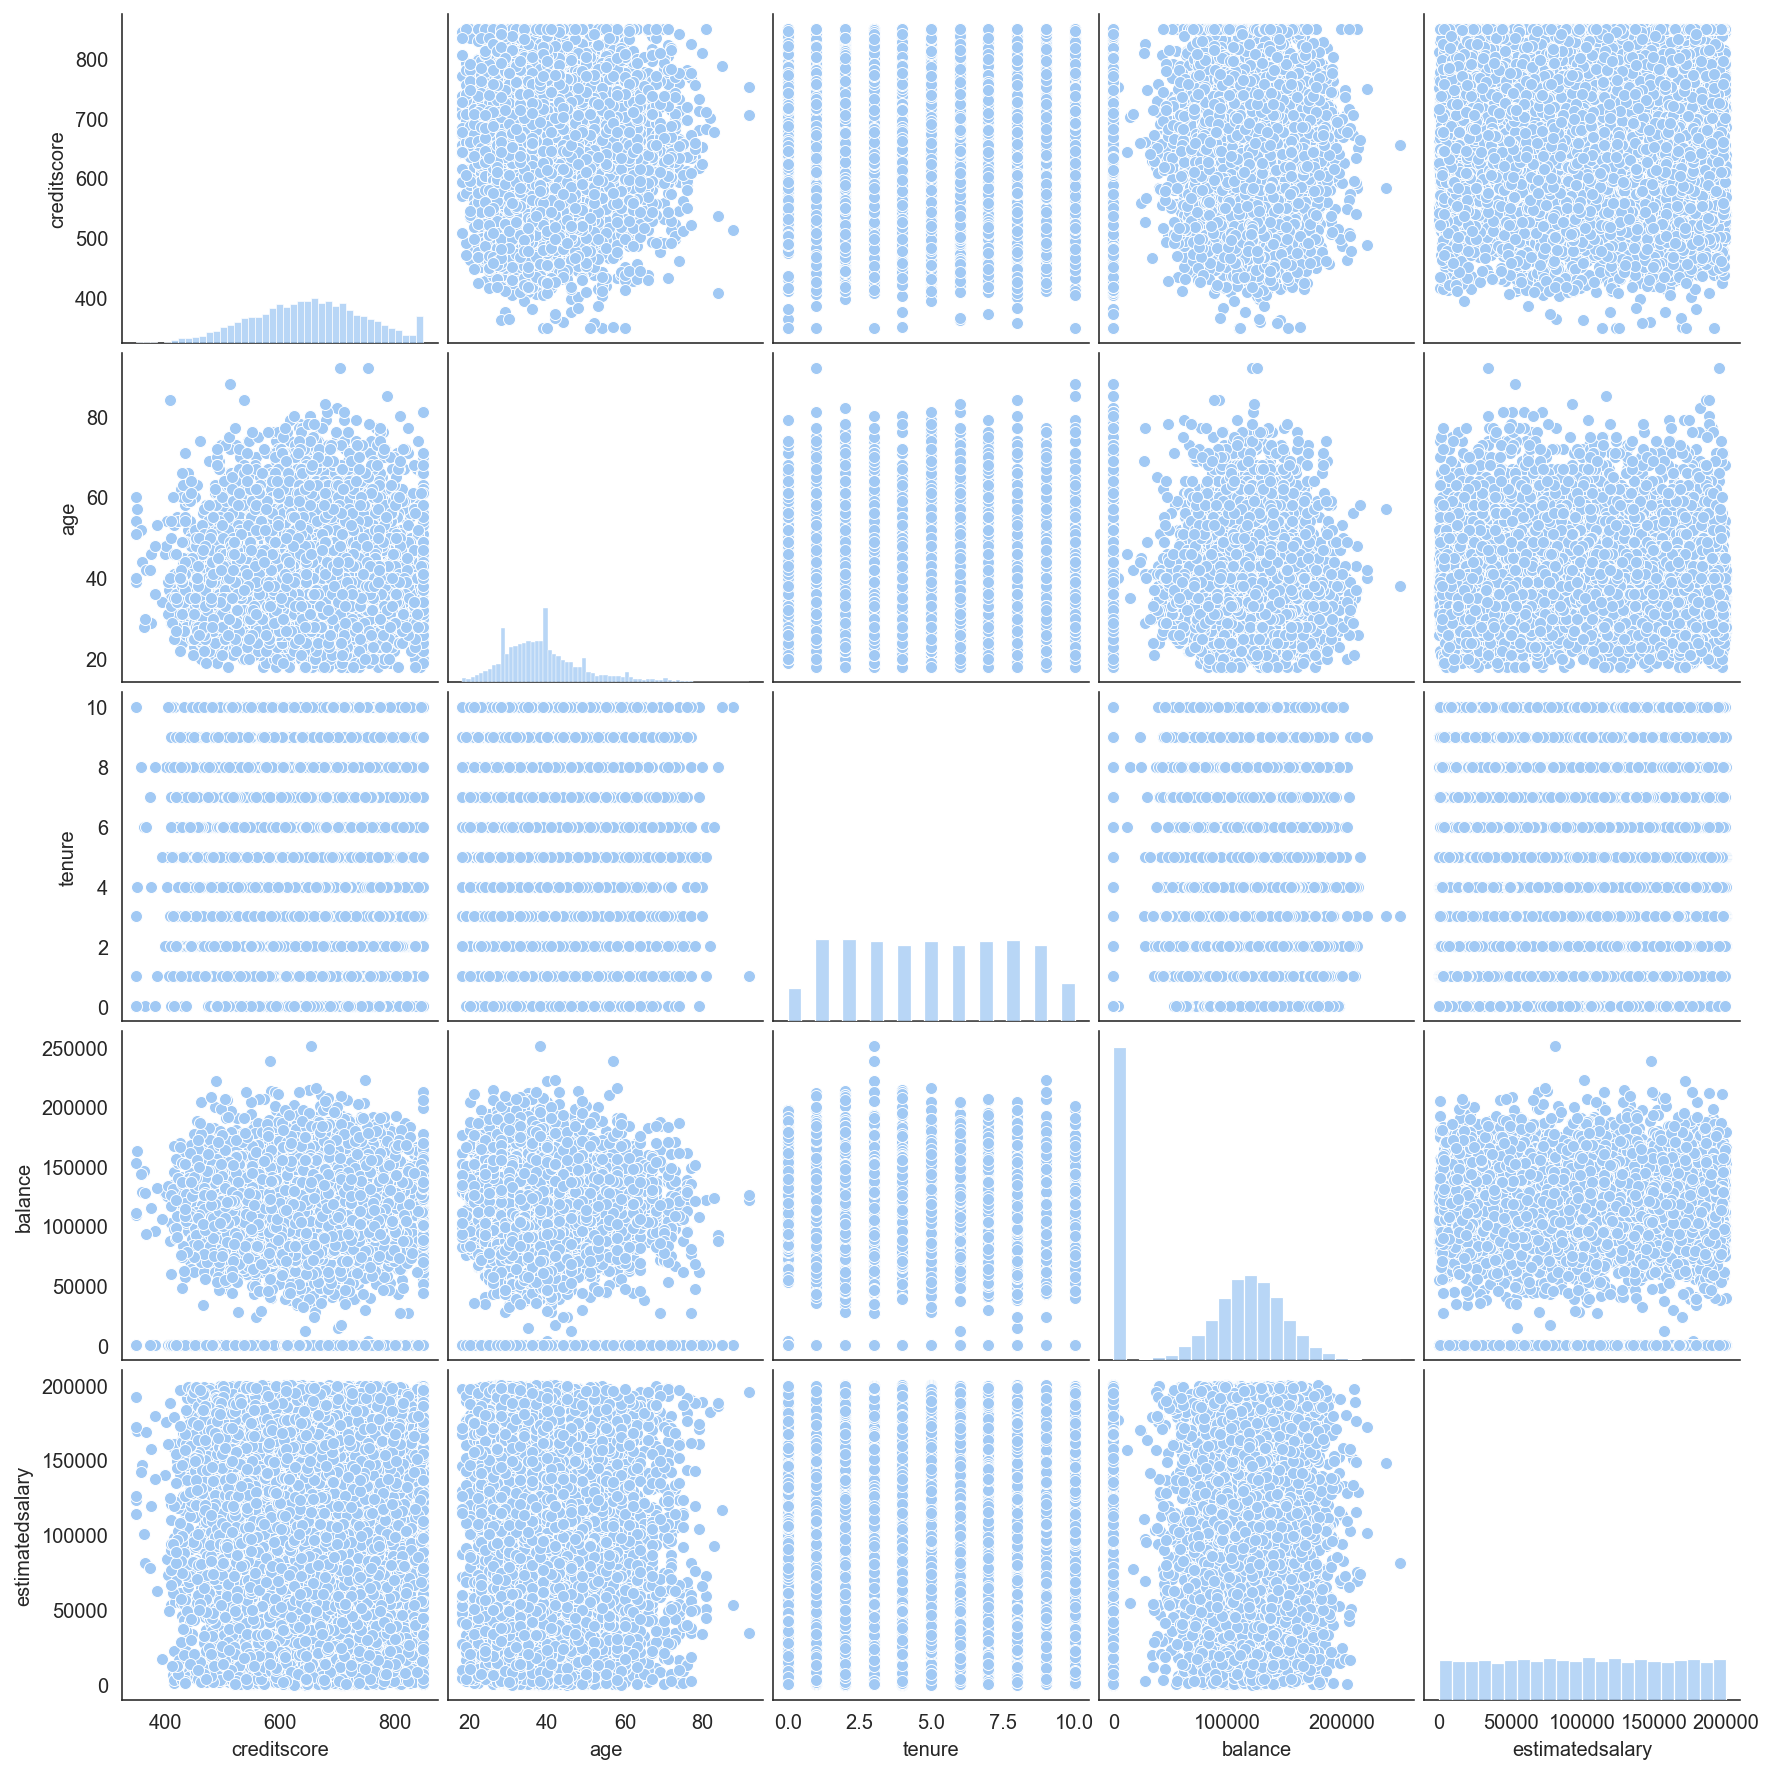

In [10]:
plt.figure(figsize=(21,21))
sns.pairplot(data[['creditscore', 'gender', 'age', 'tenure', 'balance', 'estimatedsalary']], palette = "husl")
#g.map_lower(sns.kdeplot, levels=4, color=".2")
plt.show()

In [11]:
data.duplicated().sum()

0

In [12]:
data.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

In [13]:
data[['customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited']].duplicated().sum()

0

In [14]:
data[['surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited']].duplicated().sum()

0

In [15]:
data.surname.nunique()

2932

In [16]:
data.geography.value_counts().to_frame()

,geography
France,5014
Germany,2509
Spain,2477


In [17]:
data.gender.value_counts().to_frame()

,gender
Male,5457
Female,4543


In [18]:
data.tenure.value_counts().to_frame()

,tenure
1.0,952
2.0,950
8.0,933
3.0,928
5.0,927
7.0,925
4.0,885
9.0,882
6.0,881
10.0,446


In [19]:
# заполним пропуски медианой
data.tenure = data.tenure.fillna(data.tenure.median()) 

In [20]:
data.numofproducts.value_counts()

1    5084
2    4590
3     266
4      60
Name: numofproducts, dtype: int64

In [21]:
data = data.drop(['surname', 'rownumber', 'customerid'], axis=1)
data

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [22]:
# преобразуем категориальные призкаки - geography и gender, избежим ловушки

data_ohe = pd.get_dummies(data)
data_ohe = data_ohe.drop('gender_Female', axis=1)
data_ohe

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_France,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,1,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,1,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,1,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,1,0,0,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,0,1,0,1


In [23]:
data_ohe.columns

Index(['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited', 'geography_France',
       'geography_Germany', 'geography_Spain', 'gender_Male'],
      dtype='object')

In [24]:
numeric = ['creditscore', 'age', 'tenure', 'balance', 'estimatedsalary']

In [25]:
train, test = train_test_split(data_ohe, test_size=0.4, random_state=12345)

features_train = train.drop('exited', axis=1)
target_train = train['exited']

features_1 = test.drop('exited', axis=1)
target_1 = test['exited']

features_val, features_test, target_val, target_test = train_test_split(features_1, target_1, test_size=0.5,random_state=12345)

In [26]:
pd.DataFrame({'sample':['train', 'val', 'test'], 
              'feature_size':[features_train.shape, features_val.shape, features_test.shape], 
              'target_size':[target_train.shape, target_val.shape, target_test.shape]})

,sample,feature_size,target_size
0,train,"(6000, 12)","(6000,)"
1,val,"(2000, 12)","(2000,)"
2,test,"(2000, 12)","(2000,)"


In [27]:
# масштабируем все выборки

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])

features_val[numeric] = scaler.transform(features_val[numeric])

features_test[numeric] = scaler.transform(features_test[numeric])

In [28]:
display(features_train.head(5))
display(features_val.head(5))
display(features_test.head(5))

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_France,geography_Germany,geography_Spain,gender_Male
7479,-0.886751,-0.373192,1.082277,1.232271,1,1,0,-0.187705,0,0,1,1
3411,0.608663,-0.183385,1.082277,0.600563,1,0,0,-0.333945,1,0,0,0
6027,2.052152,0.480939,-0.737696,1.027098,2,0,1,1.503095,0,1,0,1
1247,-1.457915,-1.417129,0.354288,-1.233163,2,1,0,-1.071061,1,0,0,1
3716,0.130961,-1.132419,-1.101690,1.140475,1,0,0,1.524268,0,1,0,0


,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_France,geography_Germany,geography_Spain,gender_Male
8532,-0.699824,-0.373192,-1.101690,-1.233163,2,1,0,-0.015173,1,0,0,0
5799,-0.284431,0.575842,-0.737696,-1.233163,1,1,1,1.471724,1,0,0,0
5511,0.151731,-0.657902,-1.829679,0.438711,1,1,0,-1.367107,0,1,0,1
7365,-0.876366,-0.278288,1.810266,1.239884,1,1,1,-0.786517,0,0,1,0
7367,-0.481743,0.291132,1.810266,-1.233163,2,1,0,1.358533,0,0,1,1


,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_France,geography_Germany,geography_Spain,gender_Male
7041,-2.226392,-0.088482,-1.101690,-1.233163,2,1,0,0.647083,1,0,0,1
5709,-0.087120,0.006422,1.446272,-1.233163,1,1,0,-1.658410,1,0,0,0
7117,-0.917905,-0.752805,-0.009707,0.722307,1,1,1,-1.369334,0,0,1,1
7775,-0.253277,0.101325,1.810266,-1.233163,2,1,0,0.075086,0,0,1,1
8735,0.785204,-0.847708,1.810266,0.615625,1,0,1,-1.070919,1,0,0,1


Отсутствующие данные в исходном массиве заменили медианой, исключили 3 признака из данных, преобразвали данные и разбили на 3 выборки 3:1:1

## 2. Исследование задачи

Посмотрим на метрику трех моделей без преобразования выборок

In [29]:
cat_feature = [4,5,6,8,9,10,11]

In [30]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_val = model.predict(features_val)

probabilities_val = model.predict_proba(features_val)
probabilities_one_val = probabilities_val[:, 1]

auc_roc = roc_auc_score (target_val, probabilities_one_val)

print('Logistic Regression, F1:', round(f1_score(target_val, predicted_val), 3))
print('Logistic Regression, mofel.score:', model.score(features_val, target_val))
print("AUC:", round(auc_roc, 3))
print()

model = RandomForestClassifier(random_state=12345, n_estimators=68, max_depth=10, min_samples_leaf=3, class_weight='balanced')
model.fit(features_train, target_train)
predicted_val = model.predict(features_val)

probabilities_val = model.predict_proba(features_val)
probabilities_one_val = probabilities_val[:, 1]

auc_roc = roc_auc_score (target_val, probabilities_one_val)

print('Random Forest, F1:', round(f1_score(target_val, predicted_val), 3))
print('Random Forest, mofel.score:', model.score(features_val, target_val))
print("AUC:", round(auc_roc, 3))
print()

model = CatBoostClassifier(iterations=20, custom_loss=['AUC', 'Accuracy'], random_seed=63)
model.fit(features_train, target_train, cat_features=cat_feature, eval_set=(features_val, target_val), verbose=False,
         plot=True)
predicted_val = model.predict(features_val) 

probabilities_val = model.predict_proba(features_val)
probabilities_one_val = probabilities_val[:, 1]

auc_roc = roc_auc_score (target_val, probabilities_one_val)

print('CatBoostClassifier, F1:', round(f1_score(target_val, predicted_val),3))
print('CatBoostClassifier, mofel.score:', round(model.score(features_val, target_val), 3))
print("AUC:", round(auc_roc, 3))

Logistic Regression, F1: 0.489
Logistic Regression, mofel.score: 0.702
AUC: 0.764

Random Forest, F1: 0.626
Random Forest, mofel.score: 0.837
AUC: 0.853



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoostClassifier, F1: 0.581
CatBoostClassifier, mofel.score: 0.864
AUC: 0.863


In [31]:
model.tree_count_

20

RandomForestClassifier с условно случайными гиперпараметрами дает наибольшее значение f1

## 3. Борьба с дисбалансом

- увеличим долю положительного класса, сократим долю отрицательного
- посмотрим, как меняется качество модели при изменеии порога
- построим ROC-AUC для каждой модели

**Upsampling**

In [32]:
def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled = shuffle(features_upsampled, random_state=12345)
    target_upsampled = shuffle(target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

    
    
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_upsampled.shape)
print(target_upsampled.shape)

(9588, 12)
(9588,)


In [33]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_val = model.predict(features_val)
print('Logistic Regression, F1:', round(f1_score(target_val, predicted_val), 3))
print('Logistic Regression, model.score:', model.score(features_val, target_val))
print()

model = RandomForestClassifier(random_state=12345, n_estimators=68, max_depth=10, min_samples_leaf=3)
model.fit(features_upsampled, target_upsampled)
predicted_val = model.predict(features_val)
print('Random Forest, F1:', round(f1_score(target_val, predicted_val), 3))
print('Random Forest, model.score:', model.score(features_val, target_val))
print()

model = CatBoostClassifier(iterations = 20, verbose=False, random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_val = model.predict(features_val)
print('CatBoostClassifier, F1:', round(f1_score(target_val, predicted_val), 3))
print('CatBoostClassifier, model.score:', model.score(features_val, target_val)) 

Logistic Regression, F1: 0.489
Logistic Regression, model.score: 0.702

Random Forest, F1: 0.612
Random Forest, model.score: 0.8175

CatBoostClassifier, F1: 0.611
CatBoostClassifier, model.score: 0.798


Увеличение доли положительного класса не дало желаемого результата

**Downsampling**

In [34]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_sample = features_zeros.sample(frac=fraction, random_state=12345)
    target_sample = target_zeros.sample(frac=fraction, random_state=12345)
    
    features_downsampled = pd.concat([features_sample] + [features_ones])
    target_downsampled = pd.concat([target_sample] + [target_ones])
    
    features_downsampled = shuffle(features_downsampled, random_state=12345)
    target_downsampled = shuffle(target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.5)

print(features_downsampled.shape)
print(target_downsampled.shape)

(3598, 12)
(3598,)


In [35]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_val = model.predict(features_val)
print('Logistic Regression, F1:', round(f1_score(target_val, predicted_val), 3))
print('Logistic Regression, mofel.score:', model.score(features_val, target_val))
print()

model = RandomForestClassifier(random_state=12345, n_estimators=68, max_depth=10, min_samples_leaf=3)
model.fit(features_downsampled, target_downsampled)
predicted_val = model.predict(features_val)
print('Random Forest, F1:', round(f1_score(target_val, predicted_val), 3))
print('Random Forest, mofel.score:', model.score(features_val, target_val))
print()


model = CatBoostClassifier(iterations=20, verbose=False, random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_val = model.predict(features_val)      
print('CatBoostClassifier, F1:', round(f1_score(target_val, predicted_val), 3)) 
print('CatBoostClassifier, mofel.score:', model.score(features_val, target_val))

Logistic Regression, F1: 0.468
Logistic Regression, mofel.score: 0.782

Random Forest, F1: 0.628
Random Forest, mofel.score: 0.8555

CatBoostClassifier, F1: 0.645
CatBoostClassifier, mofel.score: 0.853


Снижение доли отрицательного класса в выборке обеспечило более высокое значение f1 для CatBoostClassifier

**Изменение порога**

Threshold = 0.00 | Precision = 0.209, Recall = 1.000 | F1-score = 0.346
Threshold = 0.05 | Precision = 0.235, Recall = 0.983 | F1-score = 0.380
Threshold = 0.10 | Precision = 0.277, Recall = 0.897 | F1-score = 0.423
Threshold = 0.15 | Precision = 0.327, Recall = 0.792 | F1-score = 0.463
Threshold = 0.20 | Precision = 0.370, Recall = 0.675 | F1-score = 0.478
Threshold = 0.25 | Precision = 0.426, Recall = 0.603 | F1-score = 0.499
Threshold = 0.30 | Precision = 0.454, Recall = 0.517 | F1-score = 0.483
Threshold = 0.35 | Precision = 0.488, Recall = 0.426 | F1-score = 0.455
Threshold = 0.40 | Precision = 0.502, Recall = 0.330 | F1-score = 0.398
Threshold = 0.45 | Precision = 0.522, Recall = 0.280 | F1-score = 0.364
Threshold = 0.50 | Precision = 0.563, Recall = 0.234 | F1-score = 0.331
Threshold = 0.55 | Precision = 0.621, Recall = 0.172 | F1-score = 0.270
Threshold = 0.60 | Precision = 0.654, Recall = 0.122 | F1-score = 0.206
Threshold = 0.65 | Precision = 0.647, Recall = 0.079 | F1-score 

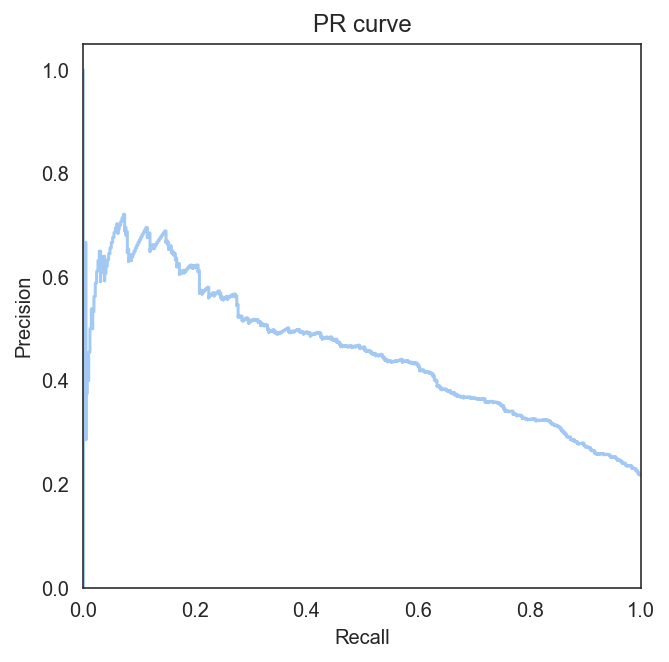

In [36]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
probabilities_val = model.predict_proba(features_val)
probabilities_one_val = probabilities_val[:, 1]

for threshold in np.arange(0, 1, 0.05):
    predicted_val = probabilities_one_val > threshold
    precision = precision_score(target_val, predicted_val)
    recall = recall_score(target_val, predicted_val)
    f1 = f1_score(target_val, predicted_val)
    print("Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f} | F1-score = {:.3f}".format(
        threshold, precision, recall, f1))

precision, recall, thresholds = precision_recall_curve(target_val, probabilities_val[:, 1])    
plt.figure(figsize=(5, 5))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR curve')
plt.show() 

Самое высокое значение f1 из полученных ниже требуемого уровня

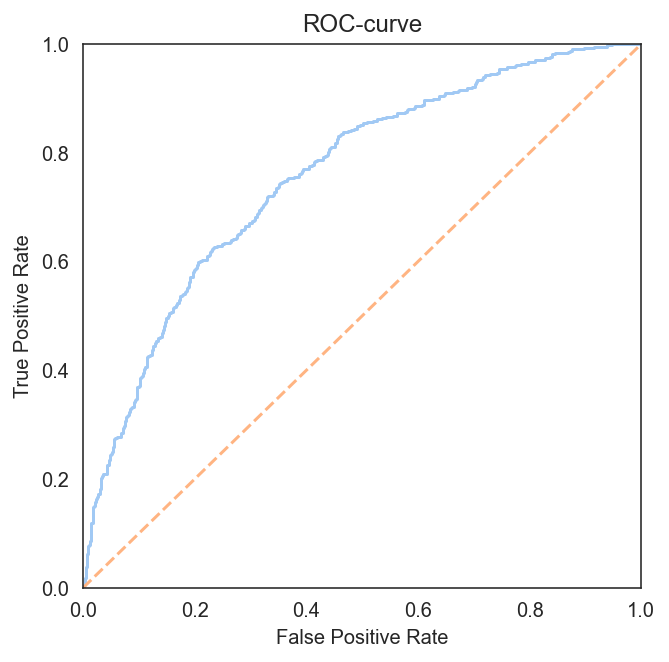

AUC: 0.759


In [37]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
probabilities_val = model.predict_proba(features_val)
probabilities_one_val = probabilities_val[:, 1]

fpr, tpr, thresholds = roc_curve(target_val, probabilities_one_val) 

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')

plt.show()

auc_roc = roc_auc_score (target_val, probabilities_one_val)

print("AUC:", round(auc_roc, 3))


Threshold = 0.00 | Precision = 0.209, Recall = 1.000 | F1-score = 0.346
Threshold = 0.05 | Precision = 0.250, Recall = 0.955 | F1-score = 0.396
Threshold = 0.10 | Precision = 0.325, Recall = 0.909 | F1-score = 0.479
Threshold = 0.15 | Precision = 0.404, Recall = 0.828 | F1-score = 0.543
Threshold = 0.20 | Precision = 0.476, Recall = 0.749 | F1-score = 0.582
Threshold = 0.25 | Precision = 0.559, Recall = 0.711 | F1-score = 0.626
Threshold = 0.30 | Precision = 0.623, Recall = 0.660 | F1-score = 0.641
Threshold = 0.35 | Precision = 0.665, Recall = 0.579 | F1-score = 0.619
Threshold = 0.40 | Precision = 0.716, Recall = 0.512 | F1-score = 0.597
Threshold = 0.45 | Precision = 0.785, Recall = 0.481 | F1-score = 0.596
Threshold = 0.50 | Precision = 0.827, Recall = 0.435 | F1-score = 0.571
Threshold = 0.55 | Precision = 0.849, Recall = 0.390 | F1-score = 0.534
Threshold = 0.60 | Precision = 0.882, Recall = 0.359 | F1-score = 0.510
Threshold = 0.65 | Precision = 0.896, Recall = 0.309 | F1-score 

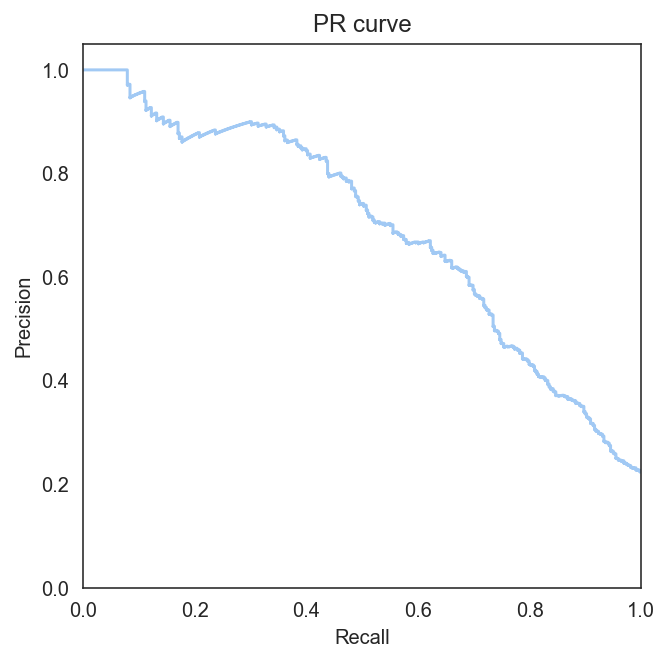

In [38]:
model = RandomForestClassifier(random_state=12345, n_estimators=68, max_depth=10, min_samples_leaf=3)
model.fit(features_train, target_train)
probabilities_val = model.predict_proba(features_val)
probabilities_one_val = probabilities_val[:, 1]

for threshold in np.arange(0, 0.95, 0.05):
    predicted_val = probabilities_one_val > threshold
    precision = precision_score(target_val, predicted_val)
    recall = recall_score(target_val, predicted_val)
    f1 = f1_score(target_val, predicted_val)
    print("Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f} | F1-score = {:.3f}".format(
        threshold, precision, recall, f1))

precision, recall, thresholds = precision_recall_curve(target_val, probabilities_val[:, 1])    
plt.figure(figsize=(5, 5))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR curve')
plt.show() 

Самое высокое значение f1 из полученных - 0,641

Threshold = 0.00 | Precision = 0.209, Recall = 1.000 | F1-score = 0.346
Threshold = 0.05 | Precision = 0.222, Recall = 0.993 | F1-score = 0.363
Threshold = 0.10 | Precision = 0.259, Recall = 0.962 | F1-score = 0.408
Threshold = 0.15 | Precision = 0.296, Recall = 0.919 | F1-score = 0.448
Threshold = 0.20 | Precision = 0.338, Recall = 0.876 | F1-score = 0.488
Threshold = 0.25 | Precision = 0.401, Recall = 0.835 | F1-score = 0.542
Threshold = 0.30 | Precision = 0.456, Recall = 0.782 | F1-score = 0.576
Threshold = 0.35 | Precision = 0.506, Recall = 0.730 | F1-score = 0.597
Threshold = 0.40 | Precision = 0.555, Recall = 0.684 | F1-score = 0.613
Threshold = 0.45 | Precision = 0.615, Recall = 0.646 | F1-score = 0.630
Threshold = 0.50 | Precision = 0.680, Recall = 0.584 | F1-score = 0.628
Threshold = 0.55 | Precision = 0.716, Recall = 0.531 | F1-score = 0.610
Threshold = 0.60 | Precision = 0.762, Recall = 0.476 | F1-score = 0.586
Threshold = 0.65 | Precision = 0.802, Recall = 0.407 | F1-score 

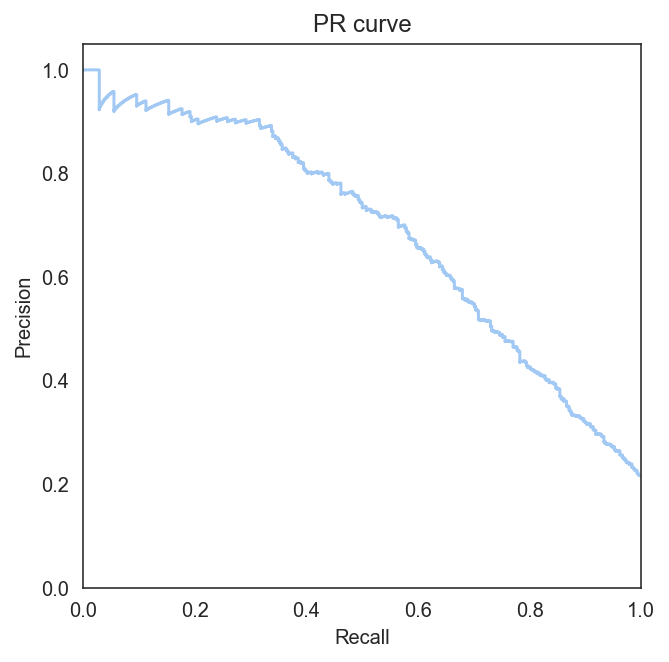

In [39]:
CatBoostClassifier(iterations=20, verbose=False, random_state=12345)
model.fit(features_downsampled, target_downsampled)
probabilities_val = model.predict_proba(features_val)
probabilities_one_val = probabilities_val[:, 1]

for threshold in np.arange(0, 0.95, 0.05):
    predicted_val = probabilities_one_val > threshold
    precision = precision_score(target_val, predicted_val)
    recall = recall_score(target_val, predicted_val)
    f1 = f1_score(target_val, predicted_val)
    print("Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f} | F1-score = {:.3f}".format(
        threshold, precision, recall, f1))

precision, recall, thresholds = precision_recall_curve(target_val, probabilities_val[:, 1])    
plt.figure(figsize=(5, 5))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR curve')
plt.show() 

Значение вероятности 0,45 дает лучшее значение f1

**Изменение параметров**

**Random forest**

In [40]:
par_grid_ensemble = {'n_estimators': [x for x in np.arange(66, 76, 2)],  'max_depth':[x for x in range(6,14)], \
                                     'class_weight': [None, 'balanced'],'min_samples_leaf':[3, 4, 5, 6]}
model = RandomForestClassifier(random_state=12345, n_jobs=-1)

grid_search = GridSearchCV(model, par_grid_ensemble, scoring='f1', cv=8)

grid_search.fit(features_train, target_train)

print(grid_search.best_params_)

{'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 68}


In [41]:
grid_search.best_params_['max_depth']

10

In [42]:
model = RandomForestClassifier(random_state=12345, n_estimators=grid_search.best_params_['n_estimators'], 
                                                   max_depth=grid_search.best_params_['max_depth'],
                                                   min_samples_leaf=grid_search.best_params_['min_samples_leaf'], 
                                                   class_weight=grid_search.best_params_['class_weight'])
model.fit(features_train, target_train)
predicted_val = model.predict(features_val)
print('Random Forest, F1:', round(f1_score(target_val, predicted_val), 3))
print('Random Forest, mofel.score:', model.score(features_val, target_val)) 
print()

Random Forest, F1: 0.634
Random Forest, mofel.score: 0.836



Получить значение f1 выше 0,641 не удалось

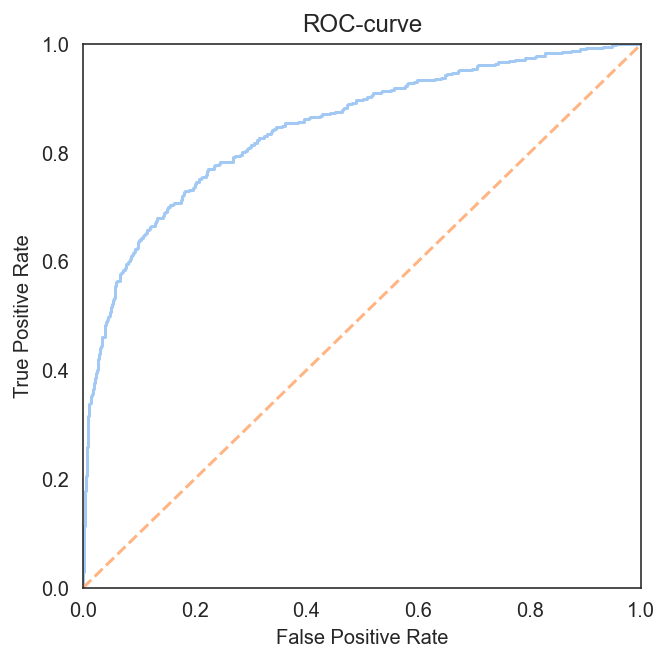

AUC: 0.848


In [43]:
model = RandomForestClassifier(random_state=12345, n_estimators=68, max_depth=10, min_samples_leaf=5, class_weight='balanced')
model.fit(features_train, target_train)

probabilities_one_val_ = probabilities_val[:, 1]

fpr_, tpr_, thresholds_ = roc_curve(target_val, probabilities_one_val_) 

plt.figure(figsize=(5, 5))
plt.plot(fpr_, tpr_, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')

plt.show()

auc_roc = roc_auc_score (target_val, probabilities_one_val_)

print("AUC:", round(auc_roc, 3))

**CatBoostClassifier**

In [44]:
t = data['exited']
tr = data.drop('exited', axis=1)
cat_features = [1, 2, 6, 7, 8]

In [45]:
par = {}
par['loss_function'] = 'Logloss'
par['iterations'] = 120
par['custom_loss'] = 'F1'
par['random_seed'] = 12345
par['learning_rate'] = 0.3

cv_data = cv(Pool(tr, label=t, cat_features=cat_features), params=par, fold_count=10, shuffle=True, 
                                 plot=False, stratified=True, verbose=False)
             
cv_data.head()

Training on fold [0/10]

bestTest = 0.3401078612
bestIteration = 29

Training on fold [1/10]

bestTest = 0.3078574711
bestIteration = 23

Training on fold [2/10]

bestTest = 0.319218214
bestIteration = 49

Training on fold [3/10]

bestTest = 0.3258772289
bestIteration = 48

Training on fold [4/10]

bestTest = 0.3357934939
bestIteration = 17

Training on fold [5/10]

bestTest = 0.3234388636
bestIteration = 26

Training on fold [6/10]

bestTest = 0.3241563284
bestIteration = 21

Training on fold [7/10]

bestTest = 0.3333319551
bestIteration = 22

Training on fold [8/10]

bestTest = 0.3333846952
bestIteration = 43

Training on fold [9/10]

bestTest = 0.332644927
bestIteration = 39



,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std
0,0,0.538082,0.006880,0.536375,0.004014,0.437720,0.037325,0.439301,0.018763
1,1,0.470642,0.006589,0.467459,0.002300,0.420857,0.055427,0.424938,0.033656
2,2,0.439400,0.007211,0.435360,0.002213,0.431238,0.035753,0.433825,0.013365
3,3,0.390059,0.007297,0.385519,0.002121,0.490152,0.035395,0.496826,0.011288
4,4,0.371176,0.006742,0.366333,0.003335,0.523066,0.035193,0.525083,0.008837


In [46]:
best_value = np.max(cv_data['test-F1-mean'])
best_iter = np.argmax(cv_data['test-F1-mean'])
print(round(best_value,3), best_iter)

0.606 39


Получить результат, больший 0,645 не удалось

Далее будем работать с моделями RandomForestClassifier и CatBoostClassifier

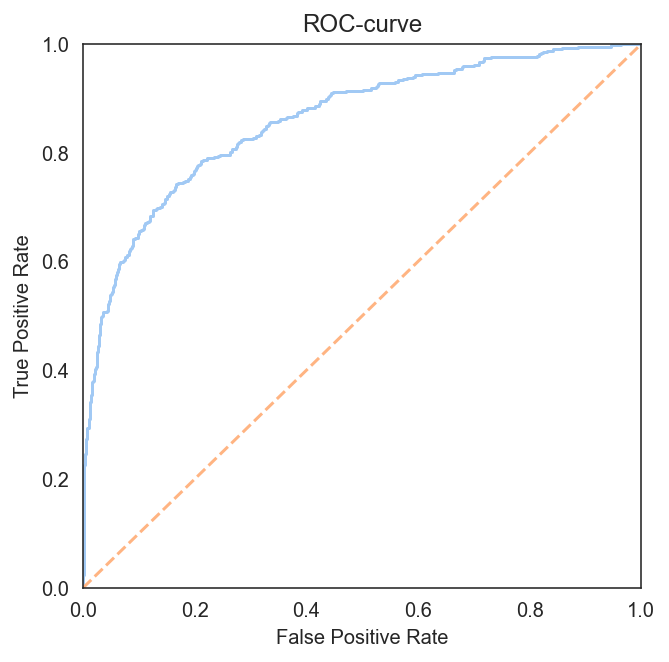

AUC: 0.862


In [47]:
model = CatBoostClassifier(iterations=21, verbose=False, random_state=12345)
model.fit(features_downsampled, target_downsampled)

probabilities_val = model.predict_proba(features_val)
probabilities_one_val = probabilities_val[:, 1]

fpr, tpr, thresholds = roc_curve(target_val, probabilities_one_val) 

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')

plt.show()

auc_roc = roc_auc_score (target_val, probabilities_one_val)

print("AUC:", round(auc_roc,3))

## 4. Тестирование моделей

In [48]:
model = CatBoostClassifier(iterations=21, verbose=False, random_state=12345)
model.fit(features_downsampled, target_downsampled)

predictions = model.predict(features_test)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 

f1 = f1_score(target_test, predictions)
acc = accuracy_score(target_test, predictions)
auc_roc = roc_auc_score (target_test, probabilities_one_test)

print("Accuracy: ", acc)
print("F1: ", round(f1, 3))
print("AUC:", round(auc_roc, 3))

Accuracy:  0.841
F1:  0.616
AUC: 0.868


In [49]:
print(classification_report(target_test, predictions)) 

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      1577
           1       0.63      0.60      0.62       423

    accuracy                           0.84      2000
   macro avg       0.76      0.75      0.76      2000
weighted avg       0.84      0.84      0.84      2000



In [50]:
fi1 = pd.DataFrame({'name':features_test.columns,'fi_cb':model.feature_importances_})
fi1 = fi1.sort_values('fi_cb',ascending=False)
fi1.loc[9, 'name'] = 'Germany'
fi1.loc[8, 'name'] = 'France'
fi1.loc[10, 'name'] = 'Spain'
fi1

,name,fi_cb
4,numofproducts,26.384362
1,age,25.378535
3,balance,12.745218
6,isactivemember,9.391032
9,Germany,8.714908
11,gender_Male,4.733400
7,estimatedsalary,4.257195
2,tenure,2.555040
0,creditscore,2.159497
8,France,1.766265


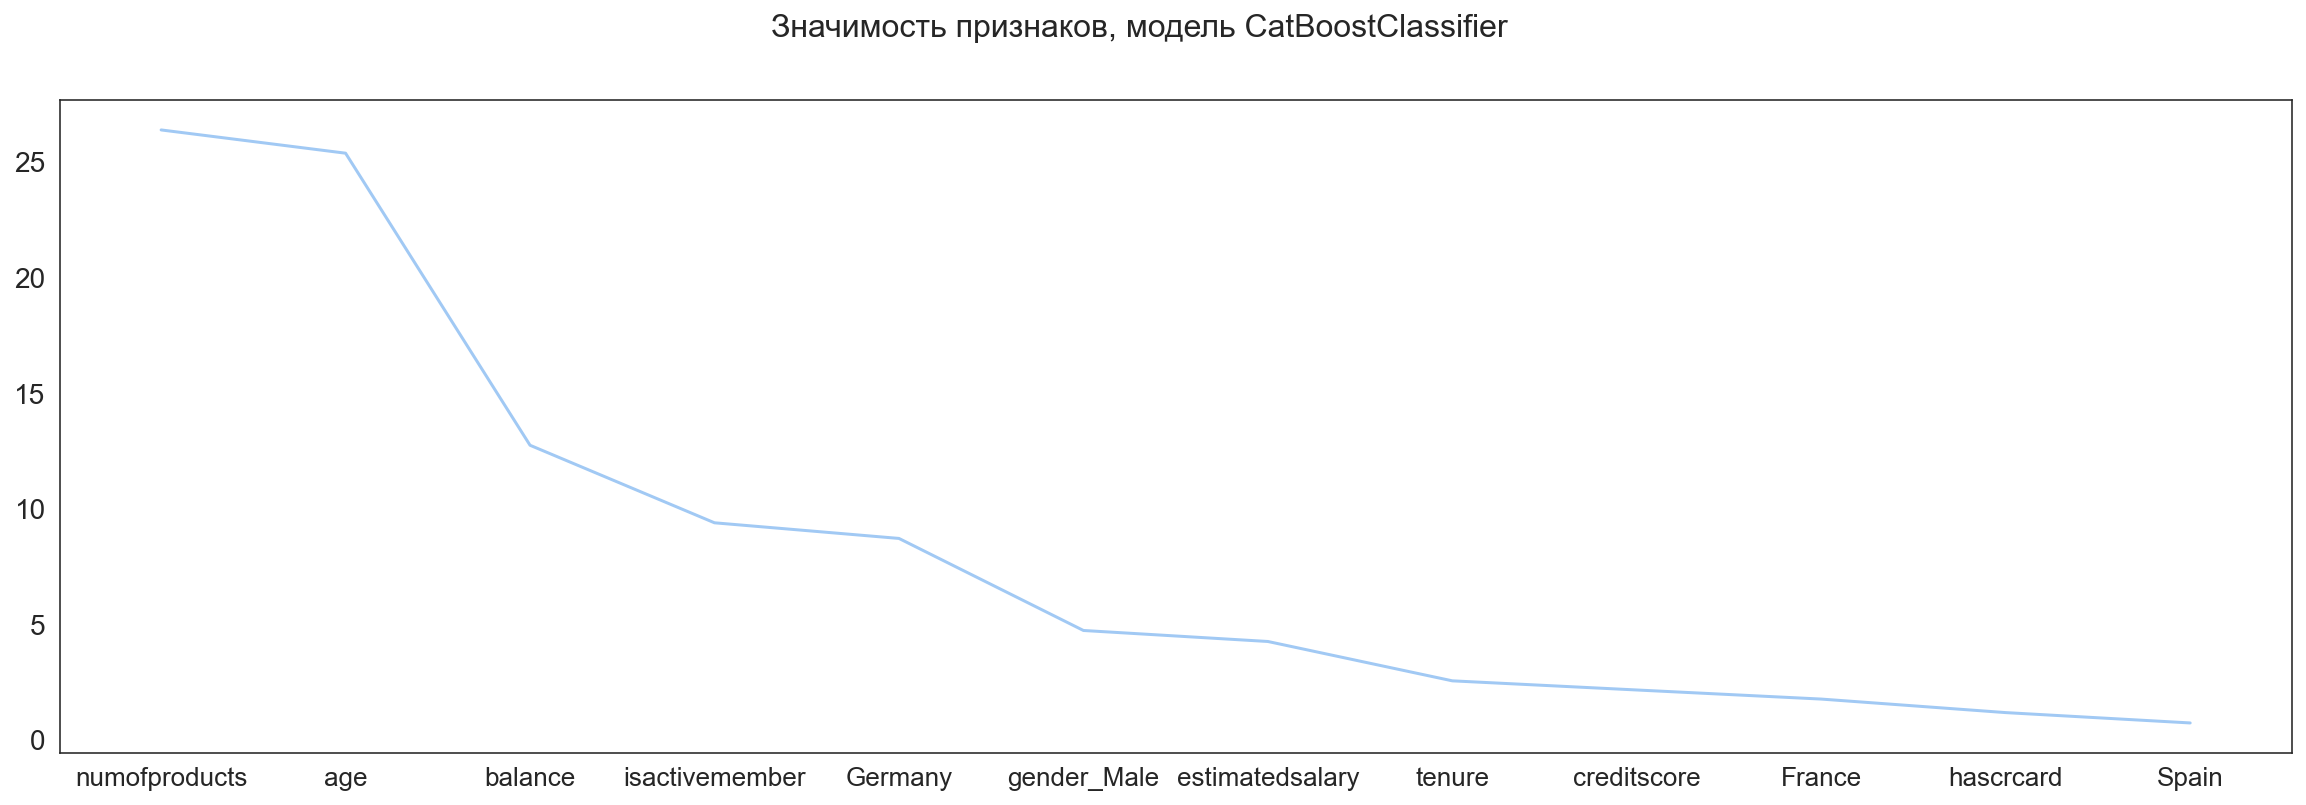

In [51]:
fig = plt.figure(figsize=(20, 6))
plt.plot(fi1.name, fi1.fi_cb)
fig.suptitle('Значимость признаков, модель CatBoostClassifier', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=14)
plt.show()

In [52]:
model = RandomForestClassifier(random_state=12345, n_estimators=68, max_depth=10, min_samples_leaf=3)
model.fit(features_train, target_train)

model.fit(features_train, target_train)

threshold = 0.3

predicted_proba = model.predict_proba(features_test)
predicted = predicted_proba [:,1] > threshold
fpr, tpr, thresholds = roc_curve(target_test, predicted) 

f1 = f1_score(target_test, predicted)
acc = accuracy_score(target_test, predicted)
auc_roc = roc_auc_score (target_test, probabilities_one_test)

print("Accuracy: ", acc)
print("F1: ", round(f1, 3))
print("AUC:", round(auc_roc, 3))

Accuracy:  0.8355
F1:  0.613
AUC: 0.868


In [53]:
fi2 = pd.DataFrame({'name':features_test.columns,'fi_rfc_1':model.feature_importances_})
fi2 = fi2.sort_values('fi_rfc_1',ascending=False)
fi2.loc[9, 'name'] = 'Germany'
fi2.loc[8, 'name'] = 'France'
fi2.loc[10, 'name'] = 'Spain'
fi2

,name,fi_rfc_1
1,age,0.311611
4,numofproducts,0.208512
3,balance,0.107068
0,creditscore,0.078817
7,estimatedsalary,0.077619
6,isactivemember,0.070224
2,tenure,0.045958
9,Germany,0.043833
11,gender_Male,0.022602
8,France,0.014562


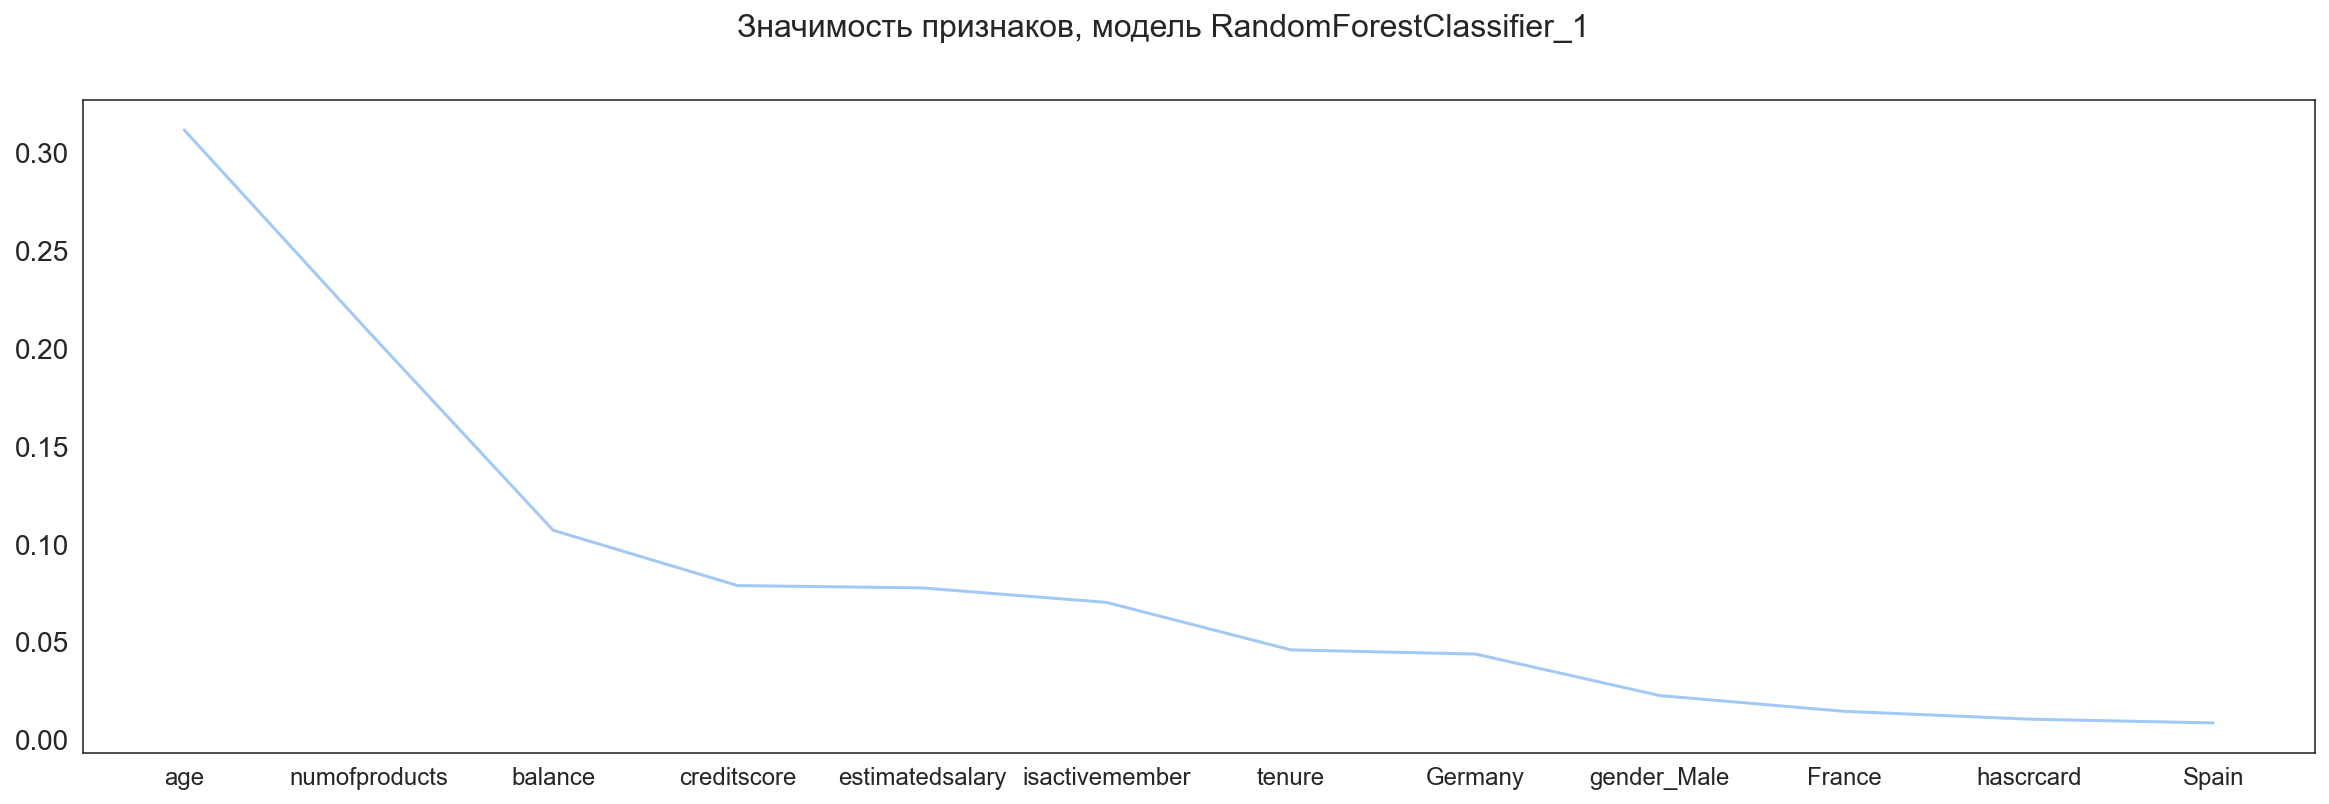

In [54]:
fig = plt.figure(figsize=(20, 6))
plt.plot(fi2.name, fi2.fi_rfc_1)
fig.suptitle('Значимость признаков, модель RandomForestClassifier_1', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.show()

In [55]:
model = RandomForestClassifier(random_state=12345, n_estimators=74, max_depth=10, min_samples_leaf=6, class_weight='balanced')
model.fit(features_train, target_train)

predicted = model.predict(features_test)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

f1 = f1_score(target_test, predicted)
acc = accuracy_score(target_test, predicted)
auc_roc = roc_auc_score (target_test, probabilities_one_test)

print("Accuracy: ", acc)
print("F1: ", round(f1, 3))
print("AUC:", round(auc_roc, 3))

Accuracy:  0.8265
F1:  0.613
AUC: 0.855


In [56]:
fi3 = pd.DataFrame({'name':features_test.columns,'fi_rfc_2':model.feature_importances_})
fi3 = fi3.sort_values('fi_rfc_2',ascending=False)
fi3.loc[9, 'name'] = 'Germany'
fi3.loc[8, 'name'] = 'France'
fi3.loc[10, 'name'] = 'Spain'
fi3

,name,fi_rfc_2
1,age,0.324647
4,numofproducts,0.181579
3,balance,0.116699
7,estimatedsalary,0.078530
0,creditscore,0.077438
6,isactivemember,0.062388
9,Germany,0.047784
2,tenure,0.046009
11,gender_Male,0.029147
8,France,0.016120


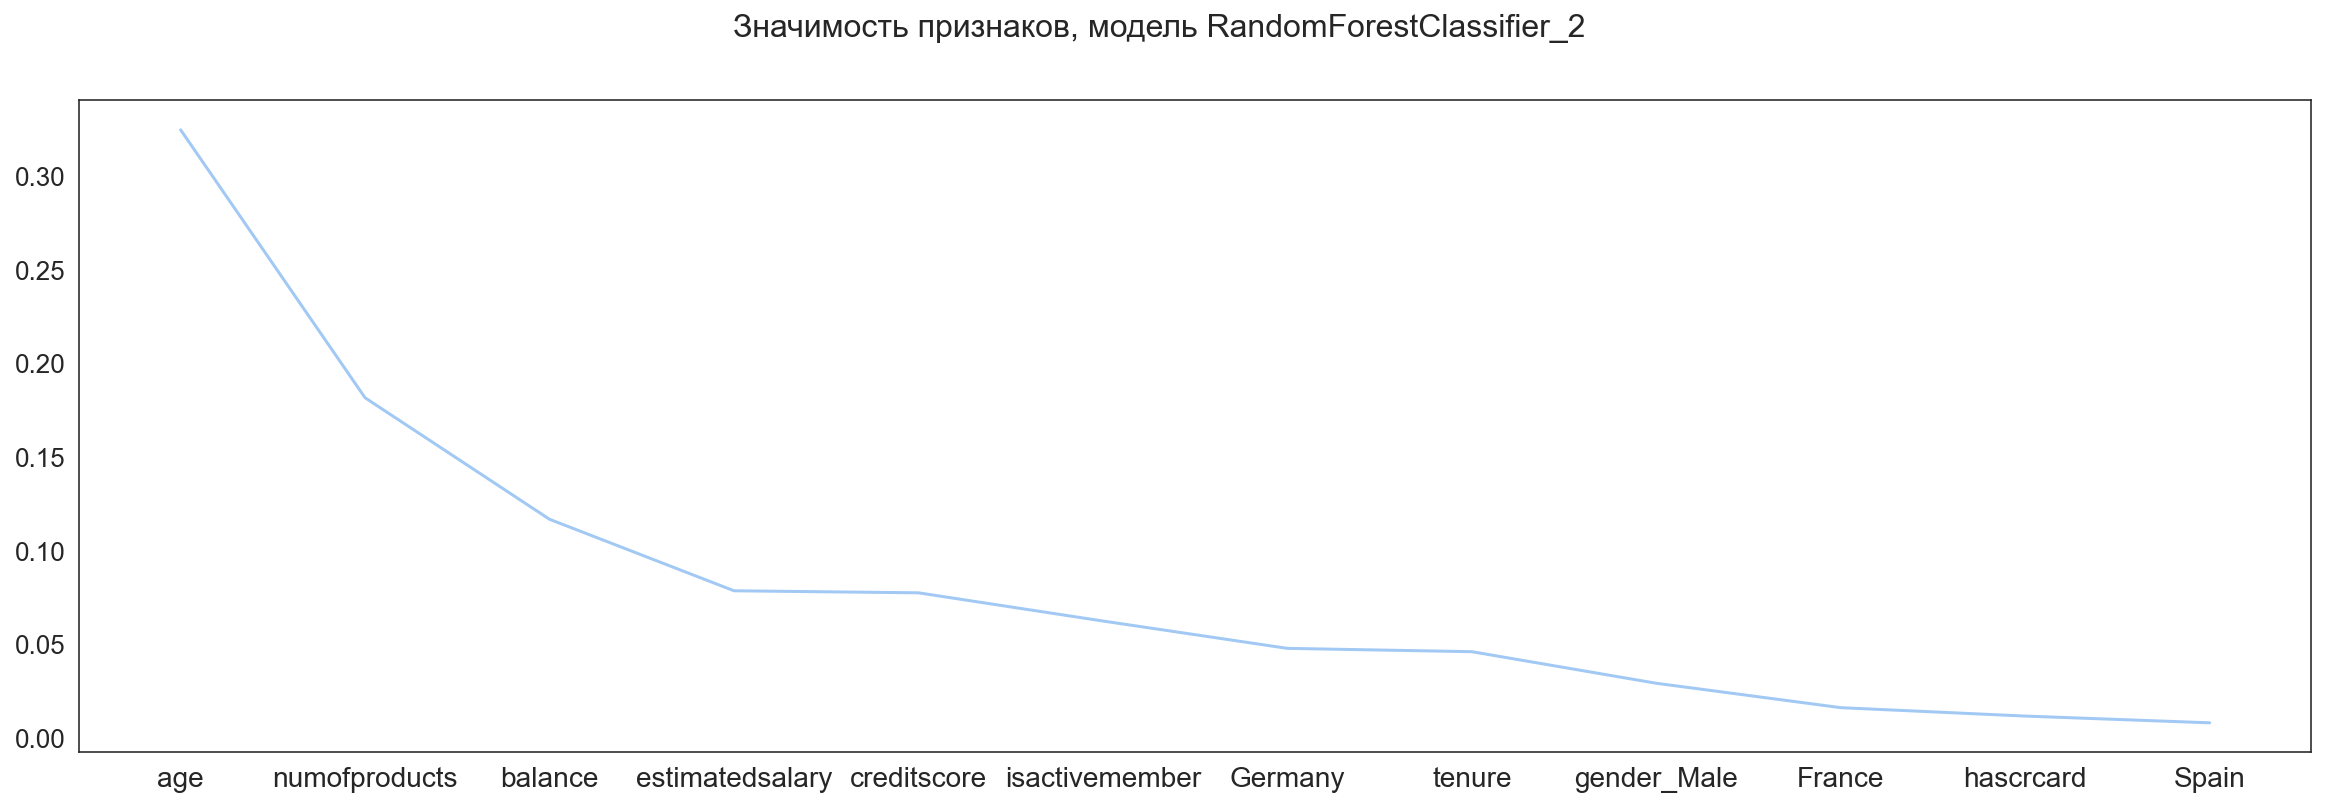

In [57]:
fig = plt.figure(figsize=(20, 6))
plt.plot(fi3.name, fi3.fi_rfc_2)
fig.suptitle('Значимость признаков, модель RandomForestClassifier_2', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=13)
plt.show()

Обе модели RandomForestClassifier (2 варианта) и CatBoostClassifier обеспечивают заданный уровень f1 > 0,59, полученные значения на валидационной и тестовых выборках - (0,641, 0,613) и (0,645, 0.616)

# Заключение

Рассмотрены 3 модели LogisticRegression, RandomForestClassifier и CatBoostClassifier. f1 выше 0,59 дают модели RandomForestClassifier и CatBoostClassifier, лучший результат обеспечивает сбалансированность, смещение порога. Для всех трех моделей значения AUC превышают 0,5 